# Confidence intervals

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

AGG_PATH = "../../data/processed/nyc_demand_zone_hour_2019_q1.parquet"

In [2]:
# Show all columns
pd.set_option("display.max_columns", None)

# Load aggregated dataset
df = pd.read_parquet(AGG_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1


Each row represents demand for a specific zone and hour. These zone-hour observations are treated as samples from the overall urban demand process.

In [4]:
df.shape

(296807, 10)

In [5]:
df["demand"].describe()

count    296807.000000
mean         73.795578
std         140.608946
min           1.000000
25%           1.000000
50%           6.000000
75%          75.000000
max        1390.000000
Name: demand, dtype: float64

## Confidence interval for the mean hourly demand
Compute a 95% confidence interval for the mean hourly ride demand per zone using the Student t distribution.

In [7]:
x = df["demand"].values

mean_demand = np.mean(x)
std_demand = np.std(x, ddof=1)
n = len(x)

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)

ci_low = mean_demand - t_crit * std_demand / np.sqrt(n)
ci_high = mean_demand + t_crit * std_demand / np.sqrt(n)

mean_demand, ci_low, ci_high


(np.float64(73.7955775975634),
 np.float64(73.28972294974119),
 np.float64(74.3014322453856))

## Confidence interval for a more interpretable quantity
To obtain a more interpretable confidence interval, estimate the mean hourly demand for a single high-demand zone (zone 234 is such based on the EDA).

In [8]:
zone_id = 234

zone_data = df[df["zone_id"] == zone_id]["demand"].values

mean_z = zone_data.mean()
std_z = zone_data.std(ddof=1)
n_z = len(zone_data)

t_crit_z = stats.t.ppf(0.975, df=n_z - 1)

ci_low_z = mean_z - t_crit_z * std_z / np.sqrt(n_z)
ci_high_z = mean_z + t_crit_z * std_z / np.sqrt(n_z)

mean_z, ci_low_z, ci_high_z


(np.float64(320.36405743399723),
 np.float64(311.9936987568577),
 np.float64(328.73441611113674))

## Compare weekday vs weekend mean demand (two CIs)
Compute separate confidence intervals for weekday and weekend hourly demand to compare their central tendencies.

In [9]:
weekday = df[df["is_weekend"] == 0]["demand"].values
weekend = df[df["is_weekend"] == 1]["demand"].values

def mean_ci(x, alpha=0.05):
    n = len(x)
    mean = np.mean(x)
    std = np.std(x, ddof=1)
    t = stats.t.ppf(1 - alpha/2, df=n-1)
    low = mean - t * std / np.sqrt(n)
    high = mean + t * std / np.sqrt(n)
    return mean, low, high

mean_ci(weekday), mean_ci(weekend)


((np.float64(74.95815856198924),
  np.float64(74.34165314707238),
  np.float64(75.5746639769061)),
 (np.float64(70.88061447562777),
  np.float64(70.01007813964527),
  np.float64(71.75115081161026)))

## Bootstrap confidence interval
We estimate a bootstrap confidence interval for the mean hourly demand to avoid reliance on distributional assumptions.

In [10]:
rng = np.random.default_rng(42)

B = 2000
boot_means = []

for _ in range(B):
    sample = rng.choice(x, size=len(x), replace=True)
    boot_means.append(sample.mean())

boot_means = np.array(boot_means)

ci_boot = np.percentile(boot_means, [2.5, 97.5])
ci_boot

array([73.3116884 , 74.29417736])

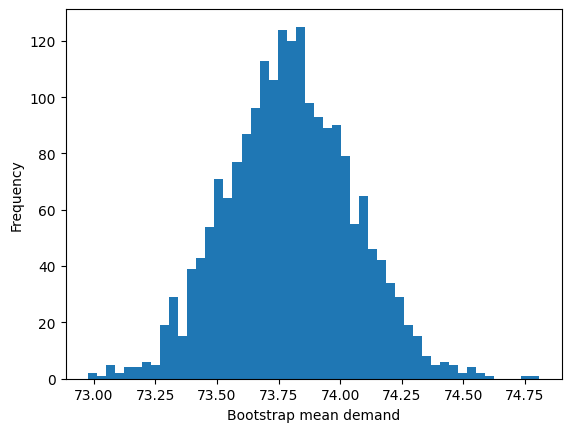

In [11]:
import matplotlib.pyplot as plt

plt.hist(boot_means, bins=50)
plt.xlabel("Bootstrap mean demand")
plt.ylabel("Frequency")
plt.show()

The confidence intervals show that, due to the very large number of zone-hour observations, the city-wide mean demand can be estimated with extremely high precision.

However, confidence intervals computed at the zone level are wider and more informative for operational decision making, as they better reflect local demand variability.

Bootstrap confidence intervals produce similar estimates while avoiding normality assumptions, which is important given the heavy-tailed and discrete nature of ride demand.